In [10]:
from bs4 import BeautifulSoup
from collections import Counter, defaultdict
import json
import requests
import shutil
from tqdm import tqdm

headers = {"User-Agent": "My User Agent"}

In [8]:
url = input()

In [18]:
response = requests.get(url, stream=True, headers=headers)
with open('example.jpg', 'wb') as out_file:
    shutil.copyfileobj(response.raw, out_file)

In [3]:
with open("data/titlepart2href.json", encoding="utf-8") as f:
    titlepart2href = json.load(f)

In [4]:
hrefs = Counter([href for v in titlepart2href.values() for href in v])

In [5]:
hrefs.most_common(3)

[('/53101-missing', 2),
 ('/19510-romantic-doctor-teacher-kim', 2),
 ('/38301-romantic-doctor-teacher-kim-2', 2)]

In [6]:
Counter([href[0] for href in hrefs])

Counter({'/': 19461, 'h': 15})

In [7]:
optional_prefix = "https://mydramalist.com"
len([href for href in hrefs if href.startswith(optional_prefix)])

15

In [8]:
# href2dramapage = {}
with open("data/href2dramapage.json", encoding="utf-8") as f:
    href2dramapage = json.load(f)

for href in tqdm(hrefs):
    if href.startswith(optional_prefix):
        href = href[len(optional_prefix):]
        
    if href not in href2dramapage:
        
        page = requests.get(f"https://mydramalist.com{href}", headers=headers)
        href2dramapage[href] = page.text

100%|████████████████████████████████████████████████████████████████████████████| 19476/19476 [13:32<00:00, 23.96it/s]


In [9]:
len(href2dramapage)

19462

In [10]:
# %%time
# with open("data/href2dramapage.json", "w", encoding="utf-8") as fw:
#     json.dump(href2dramapage, fw, ensure_ascii=False)

CPU times: total: 30.1 s
Wall time: 31 s


In [24]:
# href2postersrc = {}

for href, page in tqdm(href2dramapage.items()):
    
    if href not in href2postersrc:
        
        soup = BeautifulSoup(page)
        
        img = soup.find("div", {"class": "col-sm-4 film-cover cover"})
        if img:

            img = img.find_all("img", {"class": "img-responsive"})
            assert len(img) == 1

            href2postersrc[href] = img[0]["src"]

100%|████████████████████████████████████████████████████████████████████████████| 19462/19462 [28:14<00:00, 11.49it/s]


In [23]:
href

'/697659-big-mouth'

In [25]:
len(href2postersrc), len(href2dramapage)

(19393, 19462)

In [49]:
postersrc_prefix = "https://i.mydramalist.com/"
postersrc_suffix = "?v=1"

href_prefix = "/"

for href, postersrc in tqdm(list(href2postersrc.items())[1000:]):
    
    assert href.startswith(href_prefix)
    assert postersrc.startswith(postersrc_prefix) and postersrc.endswith(postersrc_suffix)
    
    filename = postersrc[len(postersrc_prefix):-len(postersrc_suffix)]
    filepath = f"data/posters/{href[len(href_prefix):]}_{filename}"
    
    response = requests.get(postersrc, stream=True)
    
    with open(filepath, 'wb') as f:
        f.write(response.content)

100%|██████████████████████████████████████████████████████████████████████████| 18393/18393 [3:48:24<00:00,  1.34it/s]


In [ ]:
postersrc

'https://i.mydramalist.com/BkrBq_4c.jpg?v=1'

In [11]:
import os
posterpath2filesize = {}

root = "data/posters"

for filename in tqdm(os.listdir(root)):
    posterpath = os.path.join(root, filename)
    file_stats = os.stat(posterpath)
    
    if file_stats.st_size:
        posterpath2filesize[posterpath] = file_stats.st_size

100%|██████████████████████████████████████████████████████████████████████████| 19394/19394 [00:05<00:00, 3289.93it/s]


In [15]:
Counter(posterpath2filesize.values()).most_common(5)

[(34347, 6), (33277, 5), (33654, 5), (36560, 5), (33126, 5)]

In [21]:
[k for k, v in posterpath2filesize.items() 
 if v == min(posterpath2filesize.values())]

['data/posters\\741545-young-hoon_Q3r4v_4c.jpg']

In [20]:
[k for k, v in posterpath2filesize.items() 
 if v == max(posterpath2filesize.values())]

['data/posters\\51997-don-t-look-back_RrPKPc.jpg']

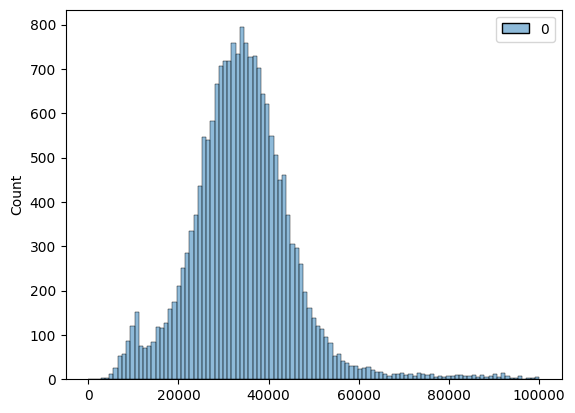

In [23]:
import seaborn as sns

sns.histplot(
    posterpath2filesize.values()
    , binrange=(0, 100_000)
);

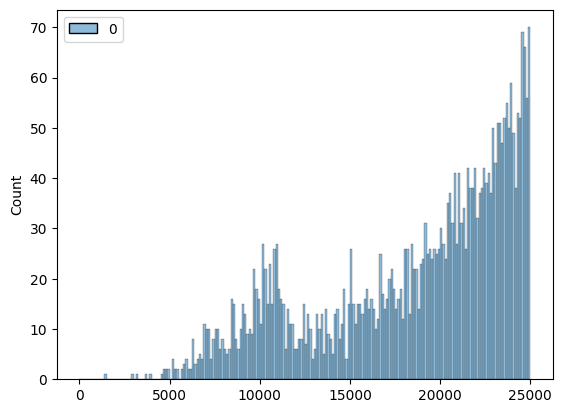

In [30]:
some_filesize = 25_000

sns.histplot(
    posterpath2filesize.values()
    , binrange=(0, some_filesize)
    , bins=200
);

In [51]:
import torch
from torchvision import transforms
from PIL import Image

tup2posterpaths = defaultdict(list)

convert_tensor = transforms.ToTensor()

for posterpath, filesize in tqdm(posterpath2filesize.items()):
    
    if filesize < some_filesize:

        img = Image.open(posterpath)

        tensor = convert_tensor(img)
        
        tup = tuple(tensor[:, :, 0].flatten().tolist())
        
        tup2posterpaths[tup].append(posterpath)

100%|██████████████████████████████████████████████████████████████████████████| 19393/19393 [00:10<00:00, 1842.04it/s]


In [60]:
sorted(tup2posterpaths.values(), key=len, reverse=True)[:4]

[['data/posters\\10748-goodbye-ani_1Nyd7_4c.jpg',
  'data/posters\\10851-fly-high-2015_vkR6D_4c.jpg',
  'data/posters\\15323-mr.-shark_6mYnp_4c.jpg',
  'data/posters\\18880-fifth-column_282yk_4c.jpg',
  'data/posters\\21900-city-of-stars_py5BQ_4c.jpg',
  'data/posters\\23739-longmen-express-3_jn6Vb_4c.jpg',
  'data/posters\\23962-invisible-man_jno88_4c.jpg',
  'data/posters\\24170-trapeze_powVy_4c.jpg',
  'data/posters\\24656-goddess-of-the-court_XlpDX_4c.jpg',
  'data/posters\\24957-control_R6LQR_4c.jpg',
  'data/posters\\25558-double-play_xZlv0_4c.jpg',
  'data/posters\\25560-moving_rJlJp_4c.jpg',
  'data/posters\\27319-the-golden-hairpin_k644m_4c.jpg',
  'data/posters\\30909-new-princess-huai-yu_2RpX7_4c.jpg',
  'data/posters\\31211-the-moon-that-rises-in-the-day_vwr1g_4c.jpg',
  'data/posters\\31799-the-mentalist_16Aey_4c.jpg',
  'data/posters\\32085-poo-yai-lee-gub-nang-ma_WE20D_4c.jpg',
  'data/posters\\32218-along-with-the-gods-3_4lKO1_4c.jpg',
  'data/posters\\32219-along-with-